In [1]:
# libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [18]:
# set a fixed seed for reproducability
np.random.seed(0)

nn_img_size = 32
num_classes = 3
learning_rate = 0.0001
num_epochs = 500
batch_size = 4

loss_mode = 'crossentropy'

loss_train_hist = []

In [3]:
def relu(x):
    """ReLU activation function"""
    return np.maximum(x, 0)

In [4]:
def relu_derivative(output):
    """derivative of the ReLU activation function"""
    output[output <= 0] = 0
    output[output > 0] = 1
    return output

In [5]:
def softmax(z):
    """softmax function to transform values to probabilities"""
    z -= z.max()
    z = np.exp(z)
    sum_z = z.sum(1, keepdims=True)
    return z / sum_z

In [6]:
def loss_mse(activation, y_batch):
    """mean squared loss function"""
    # use MSE error as loss function
    # Hint: the computed error needs to get normalized over the number of samples
    loss = ((activation - y_batch)**2).sum()
    mse = 1.0 / activation.shape[0] * loss
    return mse

In [7]:
def loss_crossentropy(activation, y_batch):
    """cross entropy loss function"""
    batch_size = y_batch.shape[0]
    loss = (-y_batch * np.log(activation)).sum() / batch_size
    return loss

In [8]:
def loss_deriv_mse(activation, y_batch):
    """derivative of the mean squared loss function"""
    dCda2 = (1 / activation.shape[0]) * (activation - y_batch)
    return dCda2

In [9]:
def loss_deriv_crossentropy(activation, y_batch):
    """derivative of the mean cross entropy loss function, that includes the derivate of the softmax
       for further explanations see here: https://deepnotes.io/softmax-crossentropy
    """
    batch_size = y_batch.shape[0]
    dCda2 = activation
    dCda2[range(batch_size), np.argmax(y_batch, axis=1)] -= 1
    dCda2 /= batch_size
    return dCda2

In [10]:
def setup_train():
    """train function"""
    # load and resize train images in three categories
    # cars = 0, flowers = 1, faces = 2 ( true_ids )
    
    basic_path = '../images/db/train/'
    
    train_images_cars = glob.glob(basic_path + 'cars/*.jpg')
    train_images_flowers = glob.glob(basic_path + 'flowers/*.jpg')
    train_images_faces = glob.glob(basic_path + 'faces/*.jpg')
    
    if not train_images_cars or not train_images_flowers or not train_images_faces:
        raise ValueError(
            'No image found! Please make sure the images are in the correct location.'
        )

    train_images = [train_images_cars, train_images_flowers, train_images_faces]
    num_rows = len(train_images_cars) + len(train_images_flowers) + len(train_images_faces)
    X_train = np.zeros((num_rows, nn_img_size * nn_img_size))
    y_train = np.zeros((num_rows, num_classes))

    counter = 0
    for (label, fnames) in enumerate(train_images):
        for fname in fnames:
            #print(label, fname)
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (nn_img_size, nn_img_size), interpolation=cv2.INTER_AREA)

            #print(label, fname, img.shape)

            # fill matrices X_train - each row is an image vector
            # y_train - one-hot encoded, put only a 1 where the label is correct for the row in X_train
            y_train[counter, label] = 1
            X_train[counter] = img.flatten().astype(np.float32)

            counter += 1

    # print(y_train)
    return X_train, y_train

In [11]:
def forward(X_batch, y_batch, W1, W2, b1, b2):
    """forward pass in the neural network """
    
    z1 = np.dot(X_batch, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    loss = None
    
    if y_batch is not None:
        if loss_mode == 'mse':
            loss = loss_mse(a2, y_batch)
        elif loss_mode == 'crossentropy':
            loss = loss_crossentropy(a2, y_batch)
        else:
            raise ValueError("Invalid loss mode")
    
    # the function should return the loss and both intermediate activations
    return loss, a2, a1

In [12]:
def backward(a2, a1, X_batch, y_batch, W2):
    
    """backward pass in the neural network """
    
    if loss_mode == 'mse':
        dCda2 = loss_deriv_mse(a2, y_batch)
    elif loss_mode == 'crossentropy':
        dCda2 = loss_deriv_crossentropy(a2, y_batch)

    dW2 = np.dot(a1.T, dCda2)
    db2 = np.sum(dCda2, axis=0, keepdims=True)

    dCda1 = np.dot(dCda2, W2.T) * relu_derivative(a1)
    dW1 = np.dot(X_batch.T, dCda1)
    db1 = np.sum(dCda1, axis=0, keepdims=True)
    
    return dW1, dW2, db1, db2

In [13]:
def train(X_train, y_train):
    """ train procedure """
    # for simplicity of this execise you don't need to find useful hyperparameter
    # I've done this for you already and every test image should work for the
    # given very small trainings database and the following parameters.
    h = 1500
    std = 0.001
    
    # YOUR CODE HERE
    W1 = std * np.random.randn(nn_img_size * nn_img_size, h)
    W2 = std * np.random.randn(h, num_classes)
    b1 = np.zeros((1, h))
    b2 = np.zeros((1, num_classes))

    # run for num_epochs
    for i in range(num_epochs):

        X_batch = None
        y_batch = None

        # use only a batch of batch_size of the training images in each run
        # sample the batch images randomly from the training set
        indices = np.random.choice(X_train.shape[0], batch_size, replace=False)
        X_batch = X_train[indices]
        y_batch = y_train[indices]

        # forward pass for two-layer neural network using ReLU as activation function
        loss, a2, a1 = forward(X_batch, y_batch, W1, W2, b1, b2)
        
        # add loss to loss_train_hist for plotting
        loss_train_hist.append(loss)

        if i % 50 == 0:
            print("iteration %d: loss %f" % (i, loss))

        # backward pass
        dW1, dW2, db1, db2 = backward(a2, a1, X_batch, y_batch, W2)


        # print("dCdb2.shape:", dCdb2.shape, dCdb1.shape)

        # depending on the derivatives of W1, and W2 regaring the cost/loss
        # we need to adapt the values in the negative direction of the
        # gradient decreasing towards the minimum
        # we weight the gradient by a learning rate
        W1 -= learning_rate * dW1
        W2 -= learning_rate * dW2
        b1 -= learning_rate * db1
        b2 -= learning_rate * db2
        
    return W1, W2, b1, b2

In [19]:
# Model Training
X_train, y_train = setup_train()
W1, W2, b1, b2 = train(X_train, y_train)

iteration 0: loss 1.071997
iteration 50: loss 0.703088
iteration 100: loss 0.401271
iteration 150: loss 0.173725
iteration 200: loss 0.076869
iteration 250: loss 0.081392
iteration 300: loss 0.025344
iteration 350: loss 0.016566
iteration 400: loss 0.041769
iteration 450: loss 0.021662


In [20]:
# predict the test images, load all test images and
# run prediction by computing the forward pass
test_images = []

test_images.append((cv2.imread('../images/db/test/flower2.jpg', cv2.IMREAD_GRAYSCALE), 1))
test_images.append((cv2.imread('../images/db/test/car.jpg', cv2.IMREAD_GRAYSCALE), 0))
test_images.append((cv2.imread('../images/db/test/face.jpg', cv2.IMREAD_GRAYSCALE), 2))

In [21]:
for ti in test_images:
    resized_ti = cv2.resize(ti[0], (nn_img_size, nn_img_size), interpolation=cv2.INTER_AREA)
    
    x_test = resized_ti.reshape(1, -1)
    
    # YOUR CODE HERE
    _, a2_test, _ = forward(x_test, None, W1, W2, b1, b2)
    
    predicted_class = np.argmax(a2_test)
    true_class = ti[1]
    
    print(f"Test output - predicted class: {predicted_class}, true class: {true_class}")
    
print("------------------------------------")
print("Test model output Weights:", W1, W2)
print("Test model output bias:", b1, b2)

Test output - predicted class: 1, true class: 1
Test output - predicted class: 0, true class: 0
Test output - predicted class: 2, true class: 2
------------------------------------
Test model output Weights: [[ 1.76405235e-03  3.87685167e-04  9.05426123e-04 ... -2.52865016e-04
  -1.04572742e-03 -2.67761992e-04]
 [ 1.32397677e-05 -1.25672467e-04  2.49828921e-04 ... -2.00943977e-04
  -1.15746849e-03 -2.71657760e-04]
 [ 1.59327362e-03  5.75925222e-04 -1.67144652e-04 ... -1.05045399e-04
   8.72292119e-04 -6.31591640e-04]
 ...
 [-2.46852567e-04  1.28360174e-03  1.53710448e-04 ...  1.27717403e-04
  -3.38985963e-04  1.17307019e-03]
 [ 3.05861646e-04  5.53040742e-04  1.58039675e-04 ...  3.63067641e-04
  -5.64008333e-04  8.34745831e-04]
 [-2.95807109e-04  4.77419086e-04  6.01930861e-04 ... -1.56378294e-03
  -7.67964202e-04  1.23255346e-03]] [[ 5.42227839e-06  1.24950699e-03 -1.40828767e-04]
 [-2.90937539e-03  9.32153395e-04  1.64361559e-03]
 [-9.24136626e-04  2.10410844e-05  1.96099213e-03]
 ..

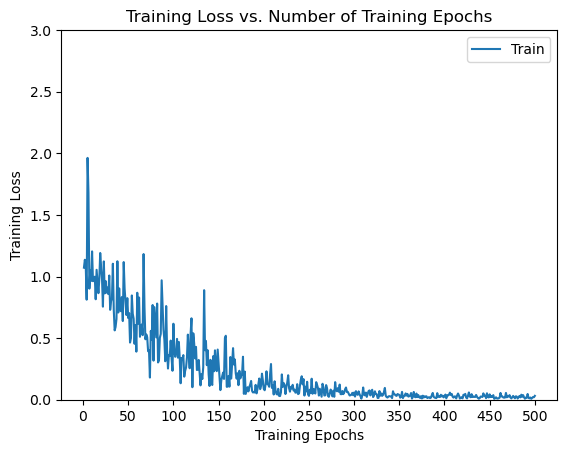

In [22]:
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1, num_epochs + 1), loss_train_hist, label="Train")
plt.ylim((0, 3.))
plt.xticks(np.arange(0, num_epochs + 1, 50.0))
plt.legend()
plt.savefig(f"../output/two_layer_nn_train_{loss_mode}.png")

plt.show()

### The figures of the both function is in output folder